![datiaperti logo](images/datiaperti_small.png)

# Spatial relations
In many applications of geoscience, for example in emergency management or risk assessment, one wants to know the spatial context of the area in which a certain event occurred and link the spatial information to external data sources through a named entity. For example, it is not enough to know the extent of a flooded area, we want to know in which administrative area it occurred. In other words, we want to know the spatial relation between the area in which an event occurred and the area that belongs to or is run by a owner or authority. In this notebook we will see how such spatial relations are implemented in GeoPandas. We will deal only with topological relations, a subclass of spatial relations that don't need a metric, that is a way to compute the distance between two spatial objects. We will start by creating some simple spatial objects, points and polygons, to see what kind of topological relations can be established and finally we will apply those topological relations between layers, defined by points and polygons over an area of interest, and the admistrative units of the Marche, one of the 20 regions of Italy.

## Python packages 
Spatial objects such as points, lines and polygons, may have one or more topological relationships such as contains, overlap, within, touches. The Python package [Shapely](https://github.com/shapely/shapely), included in GeoPandas, implements such functions for points, lines and polygons. Shapely is a Python port of [GEOS](https://libgeos.org/), the C++ port of the [Java Topology Suite (JTS)](https://github.com/locationtech/jts/), a Java implementation of topological operators. We start by importing the Python packages we are going to use. We use the minimum set of packages to get the job done.

In [7]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import contextily as cx

## Coordinate reference systems
Even if establishing the topological relationship between two spatial objects doesn't involve a metric, objects must be represented using the same coordinate reference system (CRS). We will create some spatial objects using the unprojected reference system WGS84 [EPSG:4326](https://epsg.io/4326). We will also import two datasets: the border of the Marche region and the borders of its administrative units, the municipalities of the region. We will see what spatial relations exists between our abstract layers and the Marche region and its administrative units. The two datasets have their own CRS whose ESPG code is [EPSG:32632](https://epsg.io/32632). This CRS is projected on a 2D surface using the Transverse Mercator projection and the unit of measure is the meter so, in order to use the spatial relationships between the spatial objects of our layers and the polygons of the Marche region and its administrative units we will have to change the CRS of our layers to be the same as that used for the region and its municipalities and transform the coordinates of points and polygons. 

## Spatial joins
Spatial relations are used to merge two spatial datasets A and B in which each row of A and B contains spatial objects. The merge can be based on one topological operator such as "contains", so that if object i of A contains object i of B, the value in one or more columns of B will be added to the object in A. We will not deal with spatial joins here since it's an application of the topological operators.

## Spatial objects, areas of interest, and layers
We will use spatial objects such as Points, Lines and Polygons for which a set of coordinate pairs will be assigned. A layer is a collection of one or more spatial objects that describes a certain event that occurred over an area of interest.

We begin by creating some points using (latitude, longitude) coordinate pairs and polygons defined as lists of points. The objects will use the unprojected coordinate system WGS84 ([EPSG:4326](https://epsg.io/4326)). The points represents towns in the Marche region but the polygons, and the layers they belong to, don't represent any particular event, we use them only to work with the topological operators.

In [2]:
ancona = Point(13.507224906316003, 43.603167575429865)
jesi = Point(13.242730375837372, 43.52126425797635)
corinaldo = Point(13.049195930621709, 43.648832985051826)
pergola = Point(12.836472564469215, 43.56165937486001)
fabriano = Point(12.904426736174587, 43.333135653018644)
camerino = Point(13.069720952624685, 43.13575640876881)
tolentino = Point(13.285526127229707, 43.20802624129122)
civitanova = Point(13.730063928797744, 43.30743501558867)

We create a dictionary with the names of some towns in the Marche region and their corresponding points. The Python dictionary is used to create a GeoDataFrame by setting the coordinate reference system, in our case WGS84, or more precisely EPSG:4326.

In [3]:
names = ['Ancona', 'Jesi', 'Corinaldo', 'Pergola', 'Fabriano', 'Camerino', 'Tolentino', 'Civitanova']
geometries = [ancona, jesi, corinaldo, pergola, fabriano, camerino, tolentino, civitanova]
places_dict = {'Place': names, 'geometry': geometries}
places_gdf = gpd.GeoDataFrame(places_dict, crs="EPSG:4326")

We can have a look at the WGS84 coordinate reference system. As we can see, no projection on a 2d plane is used, the units are degrees for latitude and longitude that are used to locate a point on the ellipsoid.

In [4]:
places_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
places_gdf

,Place,geometry
0,Ancona,POINT (13.50722 43.60317)
1,Jesi,POINT (13.24273 43.52126)
2,Corinaldo,POINT (13.04920 43.64883)
3,Pergola,POINT (12.83647 43.56166)
4,Fabriano,POINT (12.90443 43.33314)
5,Camerino,POINT (13.06972 43.13576)
6,Tolentino,POINT (13.28553 43.20803)
7,Civitanova,POINT (13.73006 43.30744)


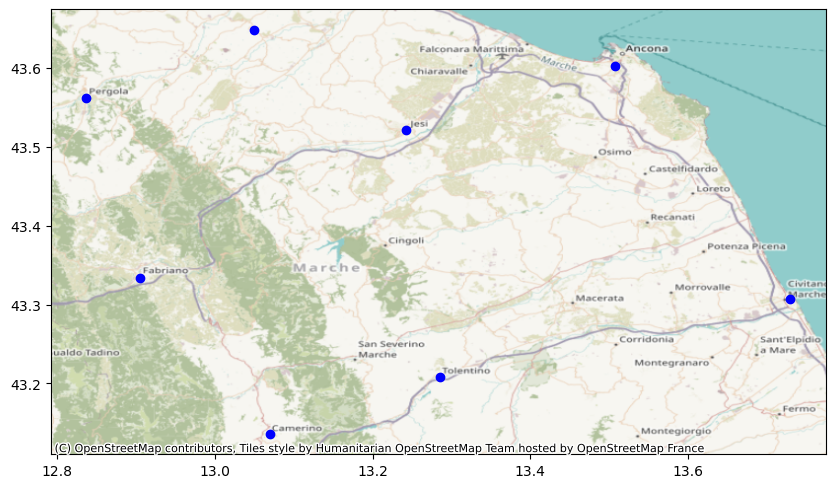

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 10))
places_gdf.plot(ax=ax, color='blue')
cx.add_basemap(ax, crs=places_gdf.crs)
#places_gdf.explore(width='50', marker_type='circle_marker', marker_kwds={'radius':'3'})

We create a polygon from the points we have defined and a GeoDataFrame using the same WGS84 coordinate reference system. A polygon starts and ends with the same point. The polygon will be part of a layer, we can name it the blue layer, to distinguish it from other layers we will create. We do not associate any meaning to our layers since in this notebook we want just to use the topological relations of the spatial objects but a layer usually represents the distribution of a certan physical or socio-economic variable over an area of interest. We will name our abstract layers by their colors. blue, orange, red, green.

In order to create a Polygon object in GeoPandas we need a list of the points that will be joined by lines. The last point in the list must be the same as the first one. We will add the polygon to the blue layer (GeoDataFrame) 

In [11]:
geometries.append(ancona)
places_poligon = Polygon(geometries)
blue_dict = {'Polygon': 'Blue Polygon', 'geometry': places_poligon}
blue_layer = gpd.GeoDataFrame(blue_dict, crs ="EPSG:4326", index=range(0,1))

<Axes: xlabel='Longitude', ylabel='Latitude'>

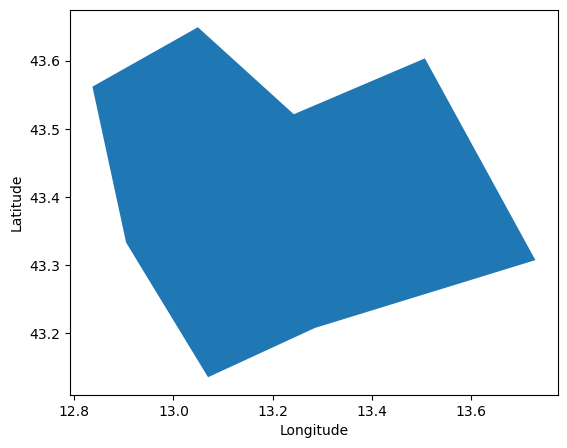

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
blue_layer.plot(ax=ax)

We create a 2nd polygon that lies within the 1st one. This 2nd polygon will be part of the orange layer.

In [13]:
pollenza = Point(13.348327008723794, 43.267747099681664)
macerata = Point(13.453648702662996, 43.29998523010854)
recanati = Point(13.549725428303592, 43.402275676832225)
cingoli = Point(13.215093036131329, 43.3753164922384)

names = ['Pollenza', 'Macerata', 'Recanati', 'Cingoli']
geometries = [pollenza, macerata, recanati, cingoli]
places_dict = {'Place': names, 'geometry': geometries}

places2_gdf = gpd.GeoDataFrame(places_dict, crs="EPSG:4326")

In [14]:
geometries.append(pollenza) 
places_poligon = Polygon(geometries)
orange_dict = {'Polygon': 'Orange Polygon', 'geometry': places_poligon}
orange_layer = gpd.GeoDataFrame(orange_dict, crs ='EPSG:4326', index=range(0,1))

<Axes: >

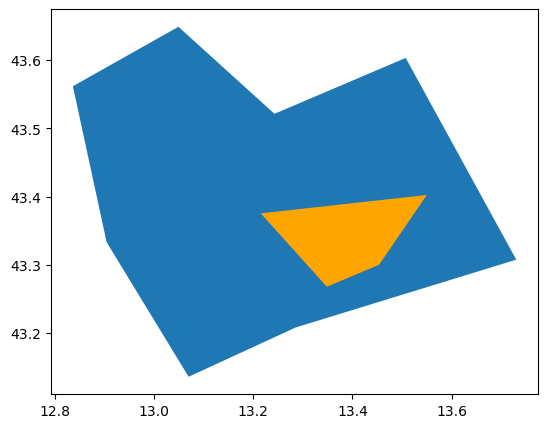

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 5))
blue_layer.plot(ax=ax)
orange_layer.plot(ax=ax, color='orange')

A 3rd polygon intersects the 1st one and touches the 2nd one. This polygon will be part of the red layer.

In [16]:
assisi = Point(12.614701534142005, 43.07119190994771)
foligno = Point(12.703168606899375, 42.9562108203491)

names = ['Assisi', 'Foligno', 'Cingoli']
geometries = [assisi, foligno, cingoli]
places = {'Place': names, 'geometry': geometries}

geometries.append(assisi)
places_polygon = Polygon(geometries)
red_dict = {'Polygon': 'Red Polygon', 'geometry': places_polygon}
red_layer = gpd.GeoDataFrame(red_dict, crs ='EPSG:4326', index=range(0,1))

The 4th polygon will be part of the green layer. It will not have any relationship with the other polygons, i.e. all the spatial relationships within, intersects, contains, between the green polygon an the other polygons will be false.

In [17]:
montalto = Point(13.60881384827591, 42.98873215474887)
fermo = Point(13.717626058195096, 43.16110296285725)
gualdo = Point(13.338057750138939, 43.067169218394255)

names = ['Montalto delle Marche', 'Fermo', 'Gualdo']
geometries = [montalto, fermo, gualdo]
places = {'Place': names, 'geometry': geometries}

geometries.append(montalto)
places_poligon = Polygon(geometries)
green_dict = {'Polygon': 'Green Polygon', 'geometry': places_poligon}
green_layer = gpd.GeoDataFrame(green_dict, crs ='EPSG:4326', index=range(0,1))

We also create a sort of mixed layer that contains the polygon of the red, green, and orange layers that we wil use later on.

In [18]:
rgo_dict = [red_dict, orange_dict, green_dict]
rgo_layer = gpd.GeoDataFrame(rgo_dict, crs='EPSG:4326', index=range(0, 3))

Now we plot our layers over the area of interest.

<Axes: xlabel='Longitude', ylabel='Latitude'>

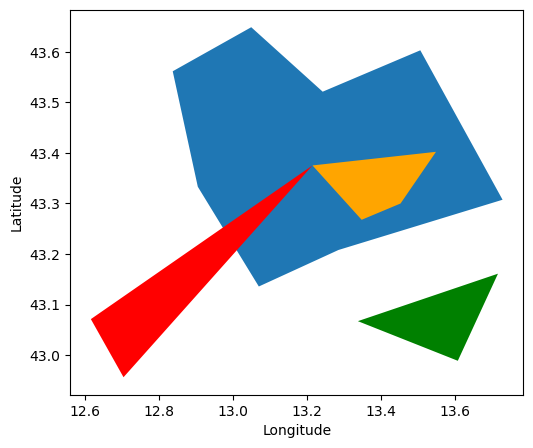

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
blue_layer.plot(ax=ax)
orange_layer.plot(ax=ax, color='orange')
red_layer.plot(ax=ax, color='red')
green_layer.plot(ax=ax, color='green')
#plt.savefig('images/polygons_with_frame.jpg')

## Topological relations
We apply the topological operators: 'within', 'intersects' and 'touch' between the polygons that we have defined. We will not use 'contains' since it's the inverse of 'within'. We will apply the topological operators to pairs of polygons from two different layers. The operators take the left operand from a polygon of one layer and the right operand from the corresponding polygon of the other layer. By "corresponding" we mean the polygons have the same index value in the two GeoDataFrame used to implement our layers. Since so far we have only one polygon in each layer their index value is 0. 

### within
From the [operator definition](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html) in Geopandas: "An object is said to be within another if at least one of its points is located in the interior and no points are located in the exterior of the other."

In [20]:
spatial_rel, = orange_layer.within(blue_layer) # the comma after the variable takes only the first returned value 
print('The polygon in the orange layer lies within the corresponding polygon in the blue layer ? {0:}'.format(spatial_rel))

The polygon in the orange layer lies within the corresponding polygon in the blue layer ? True


In [21]:
spatial_rel, = red_layer.within(blue_layer)
print('The polygon in the red layer lies within the corresponding polygon in the blue layer ? {0:}'.format(spatial_rel))

The polygon in the red layer lies within the corresponding polygon in the blue layer ? False


In [22]:
spatial_rel, = green_layer.within(blue_layer)
print('The polygon in the green layer lies within the corresponding polygon in the blue layer ? {0:}'.format(spatial_rel))

The polygon in the green layer lies within the corresponding polygon in the blue layer ? False


### intersects
From the [operator definition](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html) in GeoPandas: "An object is said to intersect another if its boundary and interior intersects in any way with those of the other."

In [23]:
red_layer.intersects(blue_layer)

0    True
dtype: bool

In [24]:
green_layer.intersects(blue_layer)

0    False
dtype: bool

### touches
From the [operator definition](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.touches.html): "An object is said to touch another if it has at least one point in common with other and its interior does not intersect with any part of the other. Overlapping features therefore do not touch." 

In [25]:
orange_layer.touches(blue_layer)

0    False
dtype: bool

In [26]:
red_layer.touches(blue_layer)

0    False
dtype: bool

In [27]:
red_layer.touches(orange_layer)

0    True
dtype: bool

## Spatial relations using a layer with more than one polygon
So far we have applied the topological operators between layers (or more technically GeoDataFrame) containing only one polygon. Obviously we will usually deal with layers containing more than one polygon and other spatial objects. In this case we have to consider that a spatial relation between layer A and layer B is applied one by one. So if we apply a spatial relation between two layers A and B, it will be applied between the 1st polygon, or more generally the geometry, of  layer A and the 1st polygon of layer B, then between the 2nd polygon of layer A and the 2nd polygon of layer B, as shown in the diagram.

![one to one](images/topological_op_one2one.svg)

So if we want to apply the within() operator between the red, orange and green polygons of the rgo layer, and the polygon in the blue layer, that corresponds to a many-to-one relation we have to use the index of the row in the layer that contains the geometry.

![many to one](images/topological_op_many2one.svg)

In [28]:
within_blue_layer = rgo_layer.within(blue_layer.loc[0, 'geometry'])
within_blue_layer

0    False
1     True
2    False
dtype: bool

One interesting thing that we can do is to add the result of the spatial relation to the layer by adding a new column to our rgo layer, e.g. 'Within Blue Layer'. 

In [33]:
rgo_layer['Within Blue Layer'] = within_blue_layer
rgo_layer

,Polygon,geometry,Within Blue Layer
0,Red Polygon,"POLYGON ((12.61470 43.07119, 12.70317 42.95621...",False
1,Orange Polygon,"POLYGON ((13.34833 43.26775, 13.45365 43.29999...",True
2,Green Polygon,"POLYGON ((13.60881 42.98873, 13.71763 43.16110...",False


Now we can filter the records for example to extract the polygons that are within the blue layer

In [35]:
rgo_layer[rgo_layer['Within Blue Layer'] == True]

,Polygon,geometry,Within Blue Layer
1,Orange Polygon,"POLYGON ((13.34833 43.26775, 13.45365 43.29999...",True


## Projections
Now we change the CRS to project the coordinates of the points and polygons onto a plane. We use the Transverse Mercator projection. We will replace the unprojected EPSG:4362 CRS that we have used so far to the EPSG:32632 CRS that uses the same datum and also a Transverse Mercator projection. The coordinate will be in meters instead of degrees.

In [26]:
blue_layer_epsg32632 = blue_layer.copy()
blue_layer_epsg32632.to_crs(epsg=32632, inplace=True)
blue_layer_epsg32632.crs

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The projection transforms the coordinates of the points in our layers. Let's print the coordinates of one polygon in the EPSG:32362 CRS to see that they are not anymore degrees of latitude and longitude.

In [27]:
str(blue_layer_epsg32632.loc[0]['geometry'])

'POLYGON ((863781.1855847789 4837677.633231176, 842896.7866065938 4827453.760055961, 826562.4360335513 4840842.432184465, 809853.1380987542 4830343.608222753, 816533.230693284 4805217.116145946, 831003.4436524143 4783935.166874516, 848146.0962037805 4792838.988502411, 883638.0862401193 4805830.531473042, 863781.1855847789 4837677.633231176))'

We apply the same transformation to the other layers

In [28]:
orange_layer_epsg32632 = orange_layer.copy()
orange_layer_epsg32632.to_crs(epsg=32632, inplace=True)

In [29]:
red_layer_epsg32632 = red_layer.copy()
red_layer_epsg32632.to_crs(epsg=32632, inplace=True)

In [30]:
green_layer_epsg32632 = green_layer.copy()
green_layer_epsg32632.to_crs(epsg=32632, inplace=True)



## Spatial relationship using a projected coordinate reference system
We use the topological operators to see whether the spatial relationships between the polygons still hold true after the change of the CRS. As we can see all of them are still valid.

### From EPSG:4326 to EPSG:32632

### within

In [31]:
orange_layer_epsg32632.within(blue_layer_epsg32632)

0    True
dtype: bool

In [32]:
red_layer_epsg32632.within(blue_layer_epsg32632)

0    False
dtype: bool

In [33]:
green_layer_epsg32632.within(blue_layer_epsg32632)

0    False
dtype: bool

### intersects

In [34]:
red_layer_epsg32632.intersects(blue_layer_epsg32632)

0    True
dtype: bool

In [35]:
red_layer_epsg32632.intersects(orange_layer_epsg32632)

0    True
dtype: bool

### touches

In [36]:
orange_layer_epsg32632.touches(blue_layer_epsg32632)

0    False
dtype: bool

In [37]:
red_layer_epsg32632.touches(blue_layer_epsg32632)

0    False
dtype: bool

In [38]:
red_layer_epsg32632.touches(orange_layer_epsg32632)

0    True
dtype: bool

## Spatial relations in the real world
Since the points and the polygons that join them represent towns and areas in the Marche region, we want to find out what spatial relationships between them hold true and what do not. For this test we use the polygon of the Marche region and the polygon of the blue area. We print the coordinate reference system used for the geometries of the Marche region to see if it is the same as the one used in our colored layers or not.

In [39]:
marche_layer = gpd.read_file('data/vector/italy/istat_confini_regioni/confini_marche/confini_marche.shp')
marche_layer.crs

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As we can see the CRS of the Marche region is EPSG:32632, that is a projected Transverse Mercator, so we will use the transformed layers to test the spatial relations between our colored layers and the layer of the Marche region. 

In [40]:
spatial_rel, = blue_layer_epsg32632.within(marche_layer)
print('The polygon in the blue layer lies within the polygon of the Marche region ? {0:}'.format(spatial_rel))

The polygon in the blue layer lies within the polygon of the Marche region ? True


In [41]:
spatial_rel, = red_layer_epsg32632.within(marche_layer)
print('The polygon in the red layer lies within the polygon of the Marche region ? {0:}'.format(spatial_rel))

The polygon in the red layer lies within the polygon of the Marche region ? False


In [42]:
spatial_rel, = red_layer_epsg32632.intersects(marche_layer)
print('The polygon in the red layer intersects the polygon of the Marche region ? {0:}'.format(spatial_rel))

The polygon in the red layer intersects the polygon of the Marche region ? True


In [43]:
spatial_rel, = green_layer_epsg32632.within(marche_layer)
print('The polygon in the green layer lies within the polygon of the Marche region ? {0:}'.format(spatial_rel))

The polygon in the green layer lies within the polygon of the Marche region ? True


We can see that the relations found hold by looking at a map of the Marche region with the blue area superimposed over it

<AxesSubplot:>

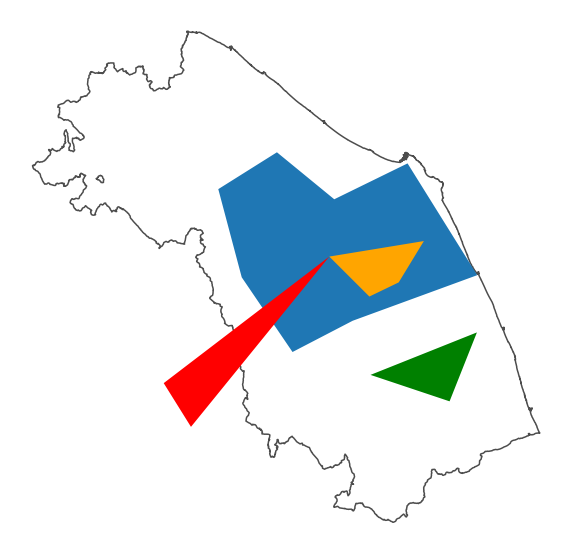

In [44]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
marche_layer.plot(ax=ax, color='None', linewidth=1.5, edgecolor='0.3')
blue_layer_epsg32632.plot(ax=ax)
red_layer_epsg32632.plot(ax=ax, color='red')
green_layer_epsg32632.plot(ax=ax, color='green')
orange_layer_epsg32632.plot(ax=ax, color='orange')
#plt.savefig('images/polygons_marche_region.jpg')

## Municipalities of the Marche region
We want to see which municipality lies within the polygon of the blue layer. We start by opening the dataset of the municipalities of the Marche region. This dataset has been extracted from the dataset of the Italian municipalities from ISTAT, the Italian National Institute of Statistics (see ref.2).

In [45]:
path_municipalities_marche = 'data/vector/italy/istat_confini_comuni/marche/marche.shp'
marche_admin_units_layer = gpd.read_file(path_municipalities_marche)
marche_admin_units_layer[:2]

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,geometry
0,3,11,44,0,44,44073,044073,Venarotta,None,0,3.020961e+07,35147.593496,"POLYGON ((866075.377 4763076.292, 866110.876 4..."
1,3,11,44,0,44,44065,044065,Rotella,None,0,2.743726e+07,30282.443322,"POLYGON ((870717.596 4769636.484, 870729.346 4..."


The coordinate reference system used for the dataset is EPSG:32632, i.e WGS84 projected using Transverse Mercator, the same coordinate reference system used in our projected colored layers.

In [46]:
marche_admin_units_layer.crs

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see that all the geometries of the municipalities, that is their polygons, lie within the geometry of the Marche region 

In [47]:
marche_geometry = marche_layer.loc[0, 'geometry']
marche_admin_units_mask = marche_admin_units_layer.within(marche_geometry)
marche_admin_units_mask.all() == True

True

Now we want to see which municipality lies within the blue area

In [48]:
blue_layer_geom = blue_layer_epsg32632.loc[0, 'geometry']
blue_layer_within_mask = marche_admin_units_layer.within(blue_layer_geom)
blue_layer_within_mask.any() == True

True

There are 34 municipalities that lie within the blue area

In [49]:
len(marche_admin_units_layer[blue_layer_within_mask])

34

We can plot them

<AxesSubplot:title={'center':'Municipalities of Marche within the blue layer'}>

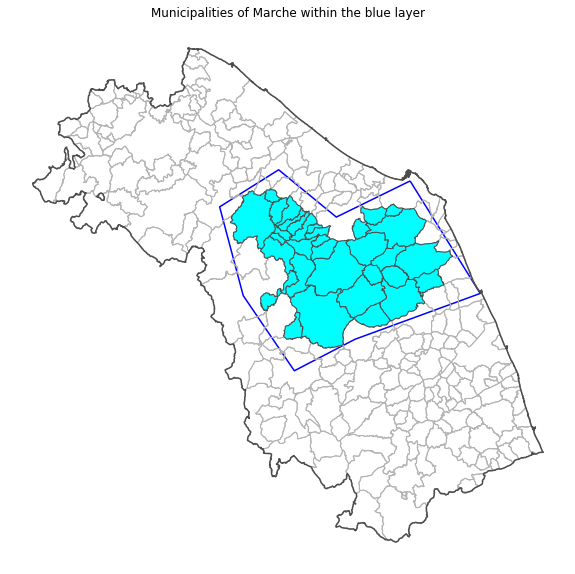

In [50]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title('Municipalities of Marche within the blue layer')
ax.axis('off')
blue_layer_epsg32632.plot(ax=ax, edgecolor='blue', linewidth=1.5, color='None')
marche_admin_units_layer.plot(color='None', ax=ax, edgecolor='0.7')
marche_layer.plot(ax=ax, color='None', linewidth=1.5, edgecolor='0.3')
marche_admin_units_layer[blue_layer_within_mask].plot(ax=ax, edgecolor='0.3', color='cyan')
#plt.savefig('images/marche_municip_within_blue_layer.jpg')

We want to add the information about the spatial relationship between a municipality and the blue area to the municipalities dataframe. We first add a column 'Spatial Relationship' with a default value 'None' for each municipality.

In [51]:
marche_admin_units_layer['Spatial Relationship'] = 'None'

Then we select the municipalities that lie within the blue area and assign the value 'W' as spatial relationship

In [52]:
marche_admin_units_layer.loc[blue_layer_within_mask, 'Spatial Relationship'] = 'Within'
marche_admin_units_layer[blue_layer_within_mask][:2]

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,geometry,Spatial Relationship
26,3,11,42,0,42,42037,042037,Poggio San Marcello,None,0,1.336288e+07,29782.364653,"POLYGON ((833342.952 4829254.041, 833488.700 4...",Within
31,3,11,42,0,42,42034,042034,Osimo,None,0,1.067377e+08,61207.327035,"POLYGON ((861832.226 4829823.260, 861855.976 4...",Within


Now we want to know which municipality intersects with the blue area. 

In [53]:
blue_layer_intersects_mask = marche_admin_units_layer.intersects(blue_layer_geom)
blue_layer_intersects_mask.any() == True

True

There are 66 municipalities that intersect our blue layer, 32 more than those that lie within it.

In [54]:
len(marche_admin_units_layer[blue_layer_intersects_mask])

66

We can plot the municipalities that intercept (or lie in) the blue layer. The union of the geometries of these municipalities contains the blue area. 

<AxesSubplot:title={'center':'Municipalities of Marche intersecting the blue layer'}>

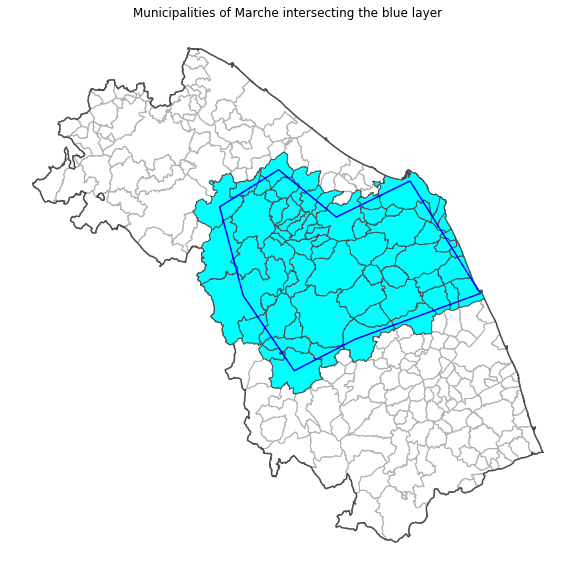

In [55]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title('Municipalities of Marche intersecting the blue layer')
ax.axis('off')
marche_admin_units_layer.plot(color='None', ax=ax, edgecolor='0.7')
marche_layer.plot(ax=ax, color='None', linewidth=1.5, edgecolor='0.3')
marche_admin_units_layer[blue_layer_intersects_mask].plot(ax=ax, edgecolor='0.3', color='cyan')
blue_layer_epsg32632.plot(ax=ax, edgecolor='blue', color='None', linewidth=1.5)
#plt.savefig('images/marche_municip_intersect_blue_layer.jpg')

## Further logic operations with masks
Again, we want to add the information about the spatial relationship 'intersects' between a municipality and the blue area to the municipalities layer. As we can see the 'within' relationship is stronger than 'intersects' so we will keep it and we will represent the 'intersects' relationship with a 'Intersects' only for those municipalities that intercepts the blue area but are not completely within it.

In [56]:
blue_layer_intersects_not_within_mask = blue_layer_intersects_mask & ~blue_layer_within_mask
len(marche_admin_units_layer[blue_layer_intersects_not_within_mask]) 

32

In [57]:
marche_admin_units_layer.loc[blue_layer_intersects_not_within_mask, 'Spatial Relationship'] = 'Intersects'
marche_admin_units_layer[blue_layer_intersects_not_within_mask][:2]

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,geometry,Spatial Relationship
35,3,11,43,0,43,43016,043016,Esanatoglia,None,0,4.790898e+07,36643.795177,"POLYGON ((823031.758 4800445.280, 823037.508 4...",Intersects
36,3,11,42,0,42,42048,042048,Sirolo,None,0,1.667685e+07,23756.396013,"POLYGON ((872330.897 4833219.473, 872338.147 4...",Intersects


Finally we plot the geometries of the municipalities that intersect our blue layer but do not lie in it.

<AxesSubplot:title={'center':'Municipalities of Marche intersecting the border of the blue layer'}>

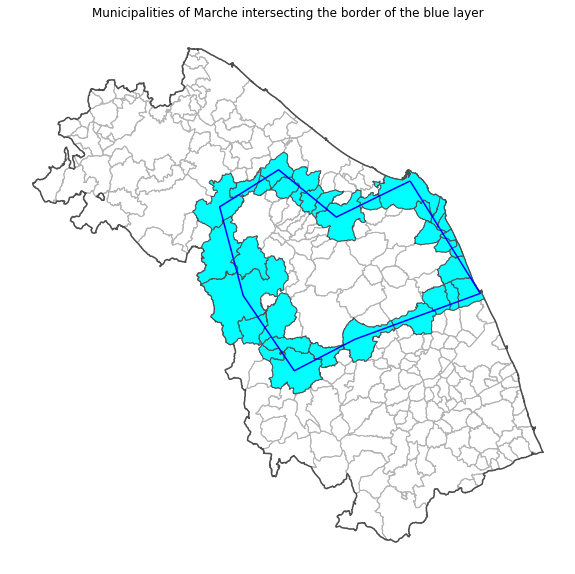

In [58]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title('Municipalities of Marche intersecting the border of the blue layer')
ax.axis('off')
marche_admin_units_layer.plot(color='None', ax=ax, edgecolor='0.7')
marche_layer.plot(ax=ax, color='None', linewidth=1.5, edgecolor='0.3')
marche_admin_units_layer[blue_layer_intersects_not_within_mask].plot(ax=ax, edgecolor='0.3', color='cyan')
blue_layer_epsg32632.plot(ax=ax, edgecolor='blue', color='None', linewidth=1.5)
#plt.savefig('images/marche_municip_intersect_border_blue_layer.jpg')

## Conclusion
We have seen some examples of spatial relations between polygons in GeoPandas. We have applied such relations to geometries of the municipalities of the Marche region in Italy. We have changed the coordinate reference system of our example layers to be the same as that used for the Marche region and its administrative units. We have also performed a further logical operation dividing the geometries of the municipalities that strictly intersect one of our fictional layer from those that lie completely in our layer using logical operators on the result of the spatial relations. Spatial relations are fundamental to perform spatial analysis over multiple layers. We want to underline that they also provide a mean to integrate the information about events, such as flooded areas, with contextual information from external data sources by using the name or identifier of a named entity whose geometry has a spatial relation with the event.       


## References
1. [Wikipedia - Spatial relation](https://en.wikipedia.org/wiki/Spatial_relation)
2. [ISTAT - Administrative Boundaries (updated to January 1st 2022](https://www.istat.it/it/archivio/222527)
3. [Papadakis et al. - Progressive, Holistic Geospatial Interlinking](https://cgi.di.uoa.gr/~koubarak/publications/2021/GeospatialInterlinking.pdf)